# IEEE Fraud Detection

In [ ]:
# Reducing memory size by changing the data types.
# https://www.kaggle.com/mjbahmani/reducing-memory-size-for-ieee
# https://www.kaggle.com/arjanso/reducing-dataframe-memory-size-by-65

import os
import gc
gc.enable()
import time

import numpy as np 
import pandas as pd 


In [ ]:
# %%time
# import Dataset to play with it
train_identity= pd.read_csv(os.getcwd() + '\\Data\\train_identity.csv', index_col='TransactionID')
train_transaction= pd.read_csv(os.getcwd() + '\\Data\\train_transaction.csv', index_col='TransactionID')
test_identity= pd.read_csv(os.getcwd() + '\\Data\\test_identity.csv', index_col='TransactionID')
test_transaction = pd.read_csv(os.getcwd() + '\\Data\\test_transaction.csv', index_col='TransactionID')
print ("Done!")

In [ ]:
print('Shape of Data:')
print(train_transaction.shape)
print(test_transaction.shape)
print(train_identity.shape)
print(test_identity.shape)

In [ ]:
# Create train & test dataset
train = train_transaction.merge(train_identity, how='left', left_index=True, right_index=True)
test = test_transaction.merge(test_identity, how='left', left_index=True, right_index=True)

del train_identity,train_transaction,test_identity, test_transaction

In [ ]:
train.info()

In [ ]:
test.info()

### IEEE Reducing Memory Size

In [ ]:
def reduce_mem_usage(df):
    start_mem_usg = df.memory_usage().sum() / 1024**2 
    print("Memory usage of properties dataframe is :",start_mem_usg," MB")
    NAlist = [] # Keeps track of columns that have missing values filled in. 
    for col in df.columns:
        if df[col].dtype != object:  # Exclude strings            
            # Print current column type
            print("******************************")
            print("Column: ",col)
            print("dtype before: ",df[col].dtype)            
            # make variables for Int, max and min
            IsInt = False
            mx = df[col].max()
            mn = df[col].min()
            print("min for this col: ",mn)
            print("max for this col: ",mx)
            # Integer does not support NA, therefore, NA needs to be filled
            if not np.isfinite(df[col]).all(): 
                NAlist.append(col)
                df[col].fillna(mn-1,inplace=True)  
                   
            # test if column can be converted to an integer
            asint = df[col].fillna(0).astype(np.int64)
            result = (df[col] - asint)
            result = result.sum()
            if result > -0.01 and result < 0.01:
                IsInt = True            
            # Make Integer/unsigned Integer datatypes
            if IsInt:
                if mn >= 0:
                    if mx < 255:
                        df[col] = df[col].astype(np.uint8)
                    elif mx < 65535:
                        df[col] = df[col].astype(np.uint16)
                    elif mx < 4294967295:
                        df[col] = df[col].astype(np.uint32)
                    else:
                        df[col] = df[col].astype(np.uint64)
                else:
                    if mn > np.iinfo(np.int8).min and mx < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif mn > np.iinfo(np.int16).min and mx < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif mn > np.iinfo(np.int32).min and mx < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif mn > np.iinfo(np.int64).min and mx < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)    
            # Make float datatypes 32 bit
            else:
                df[col] = df[col].astype(np.float32)
            
            # Print new column type
            print("dtype after: ",df[col].dtype)
            print("******************************")
    # Print final result
    print("___MEMORY USAGE AFTER COMPLETION:___")
    mem_usg = df.memory_usage().sum() / 1024**2 
    print("Memory usage is: ",mem_usg," MB")
    print("This is ",100*mem_usg/start_mem_usg,"% of the initial size")
    return df, NAlist

In [ ]:
train, NAlist = reduce_mem_usage(train)
print("_________________")
print("")
print("Warning: the following columns have missing values filled with 'df['column_name'].min() -1': ")
print("_________________")
print("")
print(NAlist)

In [ ]:
test, NAlist = reduce_mem_usage(test)
print("_________________")
print("")
print("Warning: the following columns have missing values filled with 'df['column_name'].min() -1': ")
print("_________________")
print("")
print(NAlist)

In [ ]:
train.info()
test.info()

### Saving reduced Dataset to csv and parquet

In [ ]:
train.to_csv('train.csv', index=False)
test.to_csv('test.csv', index=False)

train.to_parquet('train.gzip', compression='gzip')
test.to_parquet('test.gzip', compression='gzip')

del train, test, NAlist

# Exploratory Data Analysis

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter("ignore")

In [2]:
# train_data = pd.read_csv(os.getcwd() + '\\Data\\train.csv')
train_data = pd.read_parquet(os.getcwd() + '\\Data\\train.gzip')

In [ ]:
# Only load for prediction or later for manipulaiton:
# test_data = pd.read_parquet(os.getcwd() + '\\Data\\test.gzip')

In [3]:
train_data.info()
#test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Columns: 433 entries, isFraud to DeviceInfo
dtypes: float64(80), int64(322), object(31)
memory usage: 1.9+ GB


# Column Definitions:

| Column Names | Description |
| --- | --- |
| TransactionDT | timedelta from a given reference datetime (not an actual timestamp) |
| TransactionAMT | transaction payment amount in USD |
| ProductCD | product code, the product for each transaction |
| card1 - card6 | payment card information, such as card type, card category, issue bank, country, etc. |
| addr_ | address |
| dist | distance |
| P_ and (R__) emaildomain | purchaser and recipient email domain |
| C1-C14 | counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked. |
| D1-D15 | timedelta, such as days between previous transaction, etc. |
| M1-M9 | match, such as names on card and address, etc. |
| Vxxx | Vesta engineered rich features, including ranking, counting, and other entity relations. |

Categorical Features: ProductCD, card1 - card6, addr1, addr2, P_emaildomain, R_emaildomain, M1 - M9, DeviceType, DeviceInfo, id_12 - id_38

Rest of the variables (DeviceType, DeviceInfo, id_12 - id_38, etc.) are identity information – network connection information (IP, ISP, Proxy, etc) and digital signature (UA/browser/os/version, etc) associated with transactions. 

They're collected by Vesta’s fraud protection system and digital security partners.
(The field names are masked and pairwise dictionary will not be provided for privacy protection and contract agreement)


In [4]:
# Finding out the class proportion to determine class Imbalance.

def class_prop_binary(df, trg = 'isFraud'):
    """
    df = pandas dataframe of the dataset to determine class proportion
    trg = the column name in string format
    """
    print("The minority class count: {}".format(sum(df[trg]==1)))
    print("The majority class count: {}".format(sum(df[trg]==0)))
    print("The class proportion:")
    print("Yes : No =  {} : {}".format(round(sum(df[trg]==1)/df[trg].shape[0],3),round(sum(df[trg]==0)/df[trg].shape[0],3)))
   
class_prop_binary(train_data)
print("Highly Imbalanced data set")

The minority class count: 20663
The majority class count: 569877
The class proportion:
Yes : No =  0.035 : 0.965
Highly Imbalanced data set


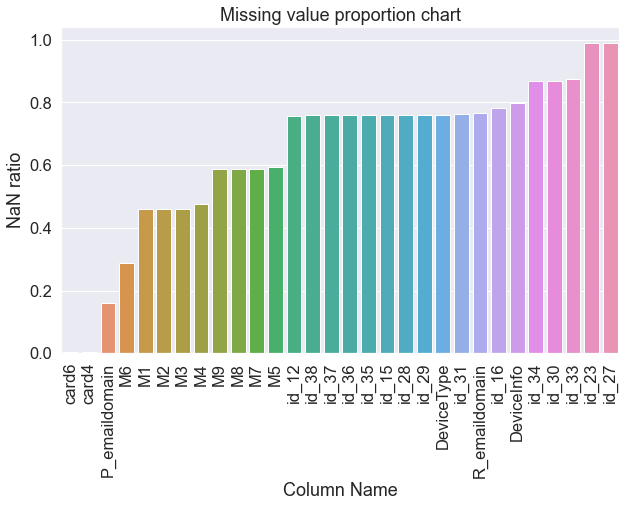

In [5]:
# train_data = pd.read_csv(os.getcwd() + '\\Data\\train.csv')

def missing_value_bars(df):
    missing_values = df.isna().sum() / len(df)
    missing_values = missing_values[missing_values > 0]
    missing_values.sort_values(inplace=True)

    missing_values = missing_values.to_frame()
    missing_values.columns = ['count']
    missing_values.index.names = ['Name']
    missing_values['Name'] = missing_values.index

    # missing_values

    sns.set(style="darkgrid", color_codes=True, font_scale = 1.5)
    fig, ax = plt.subplots(figsize=(10, 6))
    l1 = sns.barplot(ax = ax, x = 'Name', y = 'count', data=missing_values)
    l1.set(title='Missing value proportion chart', xlabel='Column Name', ylabel='NaN ratio')
    plt.xticks(rotation = 90)
    plt.show()
    return missing_values['Name'].values


missing_value_columns = missing_value_bars(train_data)


In [6]:
# Decided to Drop the missing value features for convenience of memory 
train_data.drop(axis = 1, columns=missing_value_columns, inplace = True)
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Columns: 403 entries, isFraud to id_32
dtypes: float64(80), int64(322), object(1)
memory usage: 1.8+ GB


In [16]:
# sample_train = train_data.sample(frac=0.05, replace=False, random_state=1).reset_index(drop=True)
# del train_data
# sample_train
# class_prop_binary(sample_train)
# sample_train.iloc[:, 0:20] 

In [7]:
train_data.loc[:, ['isFraud','TransactionAmt','addr1', 'addr2', 'dist1', 'dist2']].head(10)

,isFraud,TransactionAmt,addr1,addr2,dist1,dist2
0,0,68.5,315,87,19,65535
1,0,29.0,325,87,65535,65535
2,0,59.0,330,87,287,65535
3,0,50.0,476,87,65535,65535
4,0,50.0,420,87,65535,65535
5,0,49.0,272,87,36,65535
6,0,159.0,126,87,0,65535
7,0,422.5,325,87,65535,65535
8,0,15.0,337,87,65535,65535
9,0,117.0,204,87,19,65535


In [8]:
train_data.loc[:,train_data.columns[train_data.columns.str.contains("card")]].head(10)
# train_data['card2'].unique()

,card1,card2,card3,card5
0,13926,99,150,142
1,2755,404,150,102
2,4663,490,150,166
3,18132,567,150,117
4,4497,514,150,102
5,5937,555,150,226
6,12308,360,150,166
7,12695,490,150,226
8,2803,100,150,226
9,17399,111,150,224


In [9]:
train_data.loc[:,train_data.columns[train_data.columns.str.contains("C")]].head(10)

,ProductCD,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14
0,W,1,1,0,0,0,1,0,0,1,0,2,0,1,1
1,W,1,1,0,0,0,1,0,0,0,0,1,0,1,1
2,W,1,1,0,0,0,1,0,0,1,0,1,0,1,1
3,W,2,5,0,0,0,4,0,0,1,0,1,0,25,1
4,H,1,1,0,0,0,1,0,1,0,1,1,0,1,1
5,W,1,1,0,0,0,1,0,0,1,0,1,0,1,1
6,W,1,1,0,0,0,1,0,0,1,0,1,0,1,1
7,W,1,1,0,0,0,1,0,0,0,0,1,0,1,1
8,H,1,1,0,0,0,1,0,1,0,1,1,0,1,1
9,W,2,2,0,0,0,3,0,0,3,0,1,0,12,2


In [10]:
train_data.loc[:,train_data.columns[train_data.columns.str.contains("D")]].head(10)

,TransactionDT,ProductCD,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15
0,86400,W,14,65535,13,-123,65535,-84,65535,-1.0,-1.0,13,13,-84,65535,-194,0
1,86401,W,0,65535,65535,0,65535,-84,65535,-1.0,-1.0,0,-54,-84,65535,-194,0
2,86469,W,0,65535,65535,0,65535,-84,65535,-1.0,-1.0,0,315,-84,65535,-194,315
3,86499,W,112,112,0,94,0,-84,65535,-1.0,-1.0,84,-54,-84,65535,-194,111
4,86506,H,0,65535,65535,-123,65535,-84,65535,-1.0,-1.0,65535,-54,-84,65535,-194,-84
5,86510,W,0,65535,65535,0,65535,-84,65535,-1.0,-1.0,0,0,-84,65535,-194,0
6,86522,W,0,65535,65535,0,65535,-84,65535,-1.0,-1.0,0,0,-84,65535,-194,0
7,86529,W,0,65535,65535,0,65535,-84,65535,-1.0,-1.0,0,-54,-84,65535,-194,0
8,86535,H,0,65535,65535,-123,65535,-84,65535,-1.0,-1.0,65535,-54,-84,65535,-194,-84
9,86536,W,61,61,30,318,30,-84,65535,-1.0,-1.0,40,302,-84,65535,-194,318


In [11]:
train_data.loc[:,train_data.columns[train_data.columns.str.contains("V")]].head(10)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,1,1,1,1,1,1,1,1,1,0,...,255,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1,255,255,255,255,255,255,255,255,255,255,...,255,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,1,1,1,1,1,1,1,1,1,0,...,255,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
3,255,255,255,255,255,255,255,255,255,255,...,255,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
4,255,255,255,255,255,255,255,255,255,255,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1,1,1,1,1,1,1,1,1,0,...,255,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
6,1,1,1,1,1,1,1,1,1,0,...,255,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
7,255,255,255,255,255,255,255,255,255,255,...,255,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
8,255,255,255,255,255,255,255,255,255,255,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,1,1,1,1,1,1,1,1,1,0,...,255,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


In [12]:
train_data.loc[:,train_data.columns[train_data.columns.str.contains("id_")]].head(10)
# train_data['id_21'].unique()


,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,...,id_17,id_18,id_19,id_20,id_21,id_22,id_24,id_25,id_26,id_32
0,-101,0,-14,-29,-73,-101,-47,-101,-37,-101,...,99,9,99,99,99,9,10,99,99,255
1,-101,0,-14,-29,-73,-101,-47,-101,-37,-101,...,99,9,99,99,99,9,10,99,99,255
2,-101,0,-14,-29,-73,-101,-47,-101,-37,-101,...,99,9,99,99,99,9,10,99,99,255
3,-101,0,-14,-29,-73,-101,-47,-101,-37,-101,...,99,9,99,99,99,9,10,99,99,255
4,0,70787,-14,-29,-73,-101,-47,-101,-37,-101,...,166,9,542,144,99,9,10,99,99,32
5,-101,0,-14,-29,-73,-101,-47,-101,-37,-101,...,99,9,99,99,99,9,10,99,99,255
6,-101,0,-14,-29,-73,-101,-47,-101,-37,-101,...,99,9,99,99,99,9,10,99,99,255
7,-101,0,-14,-29,-73,-101,-47,-101,-37,-101,...,99,9,99,99,99,9,10,99,99,255
8,-5,98945,-14,-29,0,-5,-47,-101,-37,-101,...,166,9,621,500,99,9,10,99,99,32
9,-101,0,-14,-29,-73,-101,-47,-101,-37,-101,...,99,9,99,99,99,9,10,99,99,255


In [13]:
# train_data.loc[:,train_data.columns[train_data.columns.str.contains("M")]].head(10)
# The M_ columns were deleted due to missing values.

## Planning Next steps:

### Feature engineering:

- Decide on which categorical columns are important and Use label encoders for all categorical columns. After that use PCA to get reduced variables.
- Decide on which Vxxx, id_xx, Cx, Dx, columns are important; get rid of the highly correlated ones for each groups. After that use PCA to get reduced variables for each groups.
- Try to get unique customer id from addr1, addr2, email domains, dist, etc.
- Try to get an approximate timeseries from interpreting TransactionDT
- Try to get TimeofDay from columns Dxx

### Testing ML models with Sample dataset:

- sample and filter out a subset with similar class proportion with just numeric variables.
- test with Logistic Regression, SVC, Random forest, LGB, XGB.
- find out weakness and strength of the above algorithms.
- Use AUC, Precision/Recall, and Confusion matrix to evaluate.

### Handling class imbalance/skewness:

- Try Undersampling Majority Class.
- Try SMOTE
- Try weight-assigning in XGB or LGB

In [18]:
# Categorical Features: ProductCD, card1 - card6, addr1, addr2, P_emaildomain, R_emaildomain, M1 - M9, DeviceType, DeviceInfo, id_12 - id_38

cat_vars = ['ProductCD', 'card1', 'card2', 'card3', 'card5', 'addr1', 'addr2', 'id_13', 'id_14', 'id_17', 'id_18', 'id_19', 'id_20',
       'id_21', 'id_22', 'id_24', 'id_25', 'id_26', 'id_32']

train_data_num = train_data.copy()
train_data_num.drop(axis = 1, columns=cat_vars, inplace = True)
del train_data
train_data_num.head(10)

,isFraud,TransactionDT,TransactionAmt,dist1,dist2,C1,C2,C3,C4,C5,...,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11
0,0,86400,68.5,19,65535,1,1,0,0,0,...,0,-14,-29,-73,-101,-47,-101,-37,-101,89.0
1,0,86401,29.0,65535,65535,1,1,0,0,0,...,0,-14,-29,-73,-101,-47,-101,-37,-101,89.0
2,0,86469,59.0,287,65535,1,1,0,0,0,...,0,-14,-29,-73,-101,-47,-101,-37,-101,89.0
3,0,86499,50.0,65535,65535,2,5,0,0,0,...,0,-14,-29,-73,-101,-47,-101,-37,-101,89.0
4,0,86506,50.0,65535,65535,1,1,0,0,0,...,70787,-14,-29,-73,-101,-47,-101,-37,-101,100.0
5,0,86510,49.0,36,65535,1,1,0,0,0,...,0,-14,-29,-73,-101,-47,-101,-37,-101,89.0
6,0,86522,159.0,0,65535,1,1,0,0,0,...,0,-14,-29,-73,-101,-47,-101,-37,-101,89.0
7,0,86529,422.5,65535,65535,1,1,0,0,0,...,0,-14,-29,-73,-101,-47,-101,-37,-101,89.0
8,0,86535,15.0,65535,65535,1,1,0,0,0,...,98945,-14,-29,0,-5,-47,-101,-37,-101,100.0
9,0,86536,117.0,19,65535,2,2,0,0,0,...,0,-14,-29,-73,-101,-47,-101,-37,-101,89.0


In [28]:
train_data_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Columns: 384 entries, isFraud to id_11
dtypes: float64(80), int64(304)
memory usage: 1.7 GB


In [133]:
train_data_num_id = train_data_num[['id_01', 'id_02', 'id_03',
       'id_04', 'id_05', 'id_06', 'id_07', 'id_08', 'id_09', 'id_10',
       'id_11']].copy()


In [136]:
from sklearn import preprocessing

x = train_data_num_id.values #returns a numpy array
min_max_scaler = preprocessing.StandardScaler()
x_scaled = min_max_scaler.fit_transform(x)
train_data_num_id = pd.DataFrame(x_scaled)

In [139]:
train_data_num_id.columns = ['id_01', 'id_02', 'id_03',
       'id_04', 'id_05', 'id_06', 'id_07', 'id_08', 'id_09', 'id_10',
       'id_11']


train_data_num_id['idx'] = train_data_num_id.index       
train_data_num_id.head(10)

,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,idx
0,-0.559322,-0.386556,-0.355335,-0.35558,-0.547494,-0.538638,-0.092198,-0.086525,-0.381047,-0.381034,-0.555984,0
1,-0.559322,-0.386556,-0.355335,-0.35558,-0.547494,-0.538638,-0.092198,-0.086525,-0.381047,-0.381034,-0.555984,1
2,-0.559322,-0.386556,-0.355335,-0.35558,-0.547494,-0.538638,-0.092198,-0.086525,-0.381047,-0.381034,-0.555984,2
3,-0.559322,-0.386556,-0.355335,-0.35558,-0.547494,-0.538638,-0.092198,-0.086525,-0.381047,-0.381034,-0.555984,3
4,1.987162,0.269977,-0.355335,-0.35558,-0.547494,-0.538638,-0.092198,-0.086525,-0.381047,-0.381034,1.828165,4
5,-0.559322,-0.386556,-0.355335,-0.35558,-0.547494,-0.538638,-0.092198,-0.086525,-0.381047,-0.381034,-0.555984,5
6,-0.559322,-0.386556,-0.355335,-0.35558,-0.547494,-0.538638,-0.092198,-0.086525,-0.381047,-0.381034,-0.555984,6
7,-0.559322,-0.386556,-0.355335,-0.35558,-0.547494,-0.538638,-0.092198,-0.086525,-0.381047,-0.381034,-0.555984,7
8,1.861098,0.531136,-0.355335,-0.35558,1.763662,1.827324,-0.092198,-0.086525,-0.381047,-0.381034,1.828165,8
9,-0.559322,-0.386556,-0.355335,-0.35558,-0.547494,-0.538638,-0.092198,-0.086525,-0.381047,-0.381034,-0.555984,9
